# Analyze PM2.5 and PM10 data

In [1050]:
import geopandas as gpd
import geoplot
import numpy as np
import pandas as pd
import calendar

import matplotlib.pyplot as plt
from matplotlib import cm as cm
from matplotlib import mlab as ml
from matplotlib import gridspec
from scipy.interpolate import spline
from scipy.ndimage.filters import gaussian_filter1d
from itertools import groupby  



import seaborn as sns

plt.ion() # turn on interactive plotting
plt.rcParams['figure.figsize'] = [20, 15] # enlarge the default plotting size

from sklearn.neighbors import KernelDensity

from mpl_toolkits.basemap import Basemap

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

table_path="I:/Thailand_Haze/tables/"
#fire_path="I:/Thailand_Haze/fire_data/"
gis_path="I:/Thailand_Haze/GIS_data/"
figure_path = "I:/Thailand_Haze/figure/"

# 1. Read and process data

Read the excel file

In [1051]:
PM10_36T = pd.read_excel(table_path+'PM.xlsx', sheet_name='36T_PM10').replace(-99, np.nan)
PM10_35T = pd.read_excel(table_path+'PM.xlsx', sheet_name='35T_PM10').replace(-99, np.nan)
PM25_36T = pd.read_excel(table_path+'PM.xlsx', sheet_name='36T_PM2.5').replace(-99, np.nan)
PM25_35T = pd.read_excel(table_path+'PM.xlsx', sheet_name='35T_PM2.5').replace(-99, np.nan)

Convert the table from wide to long (melt)

In [1052]:
PM10_36T = pd.melt(PM10_36T, id_vars=['Month', 'Day'], value_vars=list(range(1995, 2020,1))).rename(columns={"variable": "year"})
PM10_35T = pd.melt(PM10_35T, id_vars=['Month', 'Day'], value_vars=list(range(1995, 2020,1))).rename(columns={"variable": "year"})
PM25_36T = pd.melt(PM25_36T, id_vars=['Month', 'Day'], value_vars=list(range(2004, 2020,1))).rename(columns={"variable": "year"})
PM25_35T = pd.melt(PM25_35T, id_vars=['Month', 'Day'], value_vars=list(range(2016, 2020,1))).rename(columns={"variable": "year"})

Create datetime field

In [1053]:
non_leap_years = ['2-29-1995','2-29-1997','2-29-1998','2-29-1999','2-29-2001','2-29-2002','2-29-2003','2-29-2005','2-29-2006','2-29-2007','2-29-2009','2-29-2010','2-29-2011','2-29-2012','2-29-2013','2-29-2014','2-29-2015','2-29-2017','2-29-2018','2-29-2019']
PM10_36T['date_time'] = PM10_36T['Month'].astype(str) +"-"+ PM10_36T['Day'].astype(str)  +"-"+ PM10_36T['year'].astype(str) 
PM10_35T['date_time'] = PM10_35T['Month'].astype(str) +"-"+ PM10_35T['Day'].astype(str)  +"-"+ PM10_35T['year'].astype(str)
PM25_36T['date_time'] = PM25_36T['Month'].astype(str) +"-"+ PM25_36T['Day'].astype(str)  +"-"+ PM25_36T['year'].astype(str) 
PM25_35T['date_time'] = PM25_35T['Month'].astype(str) +"-"+ PM25_35T['Day'].astype(str)  +"-"+ PM25_35T['year'].astype(str) 

PM10_36T = PM10_36T[~PM10_36T['date_time'].isin(non_leap_years)]
PM10_35T = PM10_35T[~PM10_35T['date_time'].isin(non_leap_years)]
PM25_36T = PM25_36T[~PM25_36T['date_time'].isin(non_leap_years)]
PM25_35T = PM25_35T[~PM25_35T['date_time'].isin(non_leap_years)]

PM10_36T['date_time']= pd.to_datetime(PM10_36T['date_time'])
PM10_35T['date_time']= pd.to_datetime(PM10_35T['date_time'])
PM25_36T['date_time']= pd.to_datetime(PM25_36T['date_time'])
PM25_35T['date_time']= pd.to_datetime(PM25_35T['date_time'])


### Thresholds for polluted days: 
- PM2.5: 
    - Thailand standard: absolute concentration > 50 for 24 h average 
    - US standard: absolute concentration > 25 for 24 h average
- PM10:
    - Thailand standard: absolute concentration > 120 for 24 h average 
    - US standard: absolute concentration > 50 for 24 h average 

### Plot total polluted days by year

Select days above the thresholds

In [1054]:
# Thailand standard
PM10_36T_pl_th = PM10_36T[PM10_36T['value']>120]
PM10_35T_pl_th = PM10_35T[PM10_35T['value']>120]

PM25_36T_pl_th = PM25_36T[PM25_36T['value']>50]
PM25_35T_pl_th = PM25_35T[PM25_35T['value']>50]

# US standard
PM10_36T_pl_us = PM10_36T[PM10_36T['value']>50]
PM10_35T_pl_us = PM10_35T[PM10_35T['value']>50]

PM25_36T_pl_us = PM25_36T[PM25_36T['value']>25]
PM25_35T_pl_us = PM25_35T[PM25_35T['value']>25]

# All days with data
PM10_36T_all = PM10_36T[~np.isnan(PM10_36T['value'])]
PM10_35T_all = PM10_35T[~np.isnan(PM10_35T['value'])]
PM25_36T_all = PM25_36T[~np.isnan(PM25_36T['value'])]
PM25_35T_all = PM25_35T[~np.isnan(PM25_35T['value'])]

Add a column (T/F) to indicate if it is a polluted day.

Organize the counts of polluted days (> thresholds) in a dataframe

In [1055]:
# Plot PM 10 bar chart
#x_pos_35T=np.arange(len(year_ls_pm10))
#x_pos_36T=np.arange(len(year_ls_pm10)) + w

# Count pollutated days of PM10
PM10_36T_pl_th_y = PM10_36T_pl_th.groupby(PM10_36T_pl_th['date_time'].dt.year)['date_time'].count()
PM10_35T_pl_th_y = PM10_35T_pl_th.groupby(PM10_35T_pl_th['date_time'].dt.year)['date_time'].count()
PM10_36T_pl_us_y = PM10_36T_pl_us.groupby(PM10_36T_pl_us['date_time'].dt.year)['date_time'].count()
PM10_35T_pl_us_y = PM10_35T_pl_us.groupby(PM10_35T_pl_us['date_time'].dt.year)['date_time'].count()

# Count pollutated days of PM2.5
PM25_36T_pl_th_y = PM25_36T_pl_th.groupby(PM25_36T_pl_th['date_time'].dt.year)['date_time'].count()
PM25_35T_pl_th_y = PM25_35T_pl_th.groupby(PM25_35T_pl_th['date_time'].dt.year)['date_time'].count()
PM25_36T_pl_us_y = PM25_36T_pl_us.groupby(PM25_36T_pl_us['date_time'].dt.year)['date_time'].count()
PM25_35T_pl_us_y = PM25_35T_pl_us.groupby(PM25_35T_pl_us['date_time'].dt.year)['date_time'].count()

# Count days that have data
PM10_36T_all_y = PM10_36T_all.groupby(PM10_36T_all['date_time'].dt.year)['date_time'].count()
PM10_35T_all_y = PM10_35T_all.groupby(PM10_35T_all['date_time'].dt.year)['date_time'].count()
PM25_36T_all_y = PM25_36T_all.groupby(PM25_36T_all['date_time'].dt.year)['date_time'].count()
PM25_35T_all_y = PM25_35T_all.groupby(PM25_35T_all['date_time'].dt.year)['date_time'].count()

PM_df = pd.concat([PM10_36T_pl_th_y,PM10_35T_pl_th_y,PM10_36T_pl_us_y,PM10_35T_pl_us_y,PM25_36T_pl_th_y,PM25_35T_pl_th_y,PM25_36T_pl_us_y,PM25_35T_pl_us_y,PM10_36T_all_y,PM10_35T_all_y,PM25_36T_all_y,PM25_35T_all_y], axis=1)
PM_df.columns=["PM10_36T_th","PM10_35T_th","PM10_36T_us","PM10_35T_us","PM25_36T_th","PM25_35T_th","PM25_36T_us","PM25_35T_us","PM10_36T_all","PM10_35T_all","PM25_36T_all","PM25_35T_all"]
PM_df = PM_df.reset_index().rename(columns={'date_time':'year'})

PM_df['PM10_36T_th_R']=PM_df['PM10_36T_th']/PM_df['PM10_36T_all']
PM_df['PM10_35T_th_R']=PM_df['PM10_35T_th']/PM_df['PM10_35T_all']
PM_df['PM10_36T_us_R']=PM_df['PM10_36T_us']/PM_df['PM10_36T_all']
PM_df['PM10_35T_us_R']=PM_df['PM10_35T_us']/PM_df['PM10_35T_all']

PM_df['PM25_36T_th_R']=PM_df['PM25_36T_th']/PM_df['PM25_36T_all']
PM_df['PM25_35T_th_R']=PM_df['PM25_35T_th']/PM_df['PM25_35T_all']
PM_df['PM25_36T_us_R']=PM_df['PM25_36T_us']/PM_df['PM25_36T_all']
PM_df['PM25_35T_us_R']=PM_df['PM25_35T_us']/PM_df['PM25_35T_all']

In [1056]:
# Calculated days in years depending on leap or non-leap yearggg
PM_df.loc[PM_df['year']%4 == 0, 'days_in_year'] = 366
PM_df.loc[PM_df['year']%4 != 0, 'days_in_year'] = 365
PM_df['PM10_36T_data_R'] = PM_df['PM10_36T_all']/ PM_df['days_in_year']
PM_df['PM10_35T_data_R'] = PM_df['PM10_35T_all']/ PM_df['days_in_year']
PM_df['PM25_36T_data_R'] = PM_df['PM25_36T_all']/ PM_df['days_in_year']
PM_df['PM25_35T_data_R'] = PM_df['PM25_35T_all']/ PM_df['days_in_year']

## Define font sizes

In [1057]:
l = 20
m = 16
ml = 18
s = 12

# 2. Analysis by Year

## 2.1 Total pollutated days per year for PM10 (Figure 1)

This figure shows total number of polluted days each year at the two stations (35T and 36T) under US and Thailand standards of polluted days.

#### Standards for polluted days
**PM10**
- Thailand standard: >120
- US standard: >50

**PM2.5**
- Thailand standard: >50
- US standard: >25

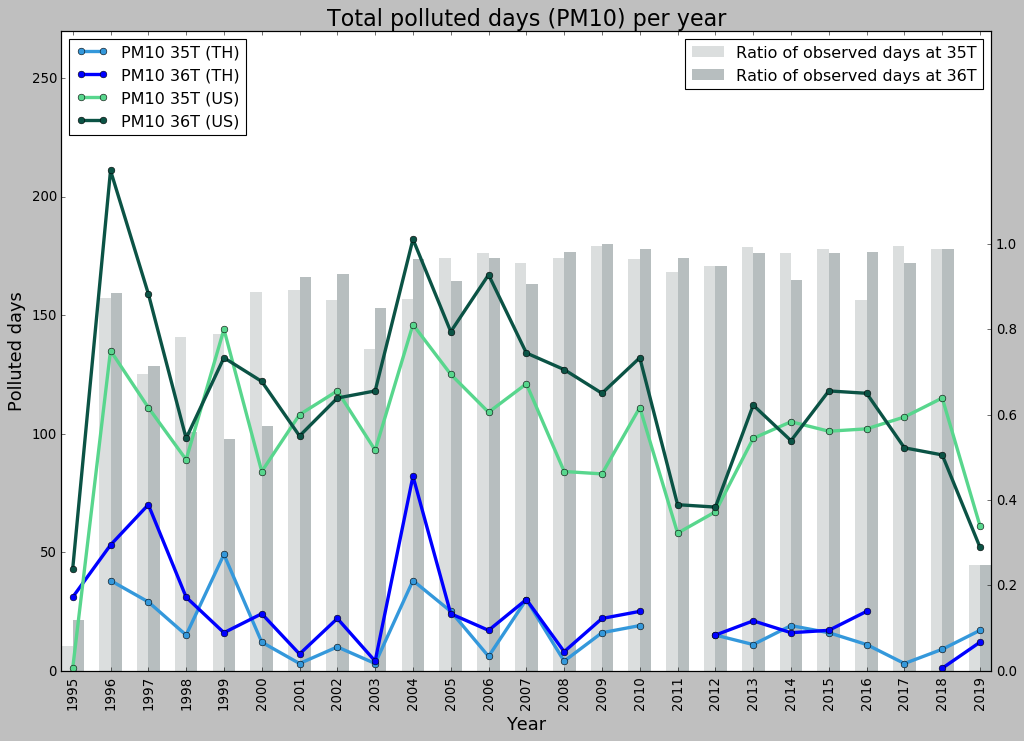

In [1058]:
year_ls = list(PM_df['year'])
#color_ls = ['grey']*len(year_ls)
#color_ls[10]='red'

plt.rcParams['figure.figsize'] = [15, 10] # enlarge the default plotting size

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# Plot bars first
w = 0.3
ax1.bar([x-w/2 for x in year_ls],PM_df['PM10_35T_data_R'],width=w,color='#CCD1D1',alpha=0.7,align='center',edgecolor = "none",label="Ratio of observed days at 35T")
ax1.bar([x+w/2 for x in year_ls],PM_df['PM10_36T_data_R'],width=w,color='#99A3A4',alpha=0.7,align='center',edgecolor = "none",label="Ratio of observed days at 36T")

# Format axis labels and ticks
ax1.xaxis.set_ticks(year_ls)
ax1.set_xticklabels(year_ls,rotation=90, fontsize=s)
ax1.set_ylim(0, 1.5)
ax1.yaxis.set_ticks([0,0.2,0.4,0.6,0.8,1.0])
ax1.yaxis.tick_right()

#ax1.yaxis.set_label_position("right")
#ax1.bar(year_ls,PM_df['PM10_36T_data_R'],color='b',alpha=0.2)


# Plot line charts
ax2.plot(year_ls, PM_df['PM10_35T_th'], marker="o", color='#3498DB', linewidth=3, label='PM10 35T (TH)')
ax2.plot(year_ls, PM_df['PM10_36T_th'], marker="o", color='b', linewidth=3, label='PM10 36T (TH)')
ax2.plot(year_ls, PM_df['PM10_35T_us'], marker="o", color='#58D68D', linewidth=3, label='PM10 35T (US)')
ax2.plot(year_ls, PM_df['PM10_36T_us'], marker="o", color='#0B5345', linewidth=3, label='PM10 36T (US)')
ax2.yaxis.tick_left()
ax2.yaxis.set_label_position("left")
ax2.set_ylim(0, 270)

# Add legend
ax2.legend(loc=2)
ax1.legend(loc=1)

ax2.set_ylabel('Polluted days',fontsize = m)
ax1.set_xlabel("Year", fontsize=m)
plt.title('Total polluted days (PM10) per year', loc='Center', fontsize=l, fontweight=0)


plt.savefig(figure_path+'figure1.png',dpi=300)
plt.show()

## 2.2 Ratio of pollutated days per year for PM10 (Figure 2)

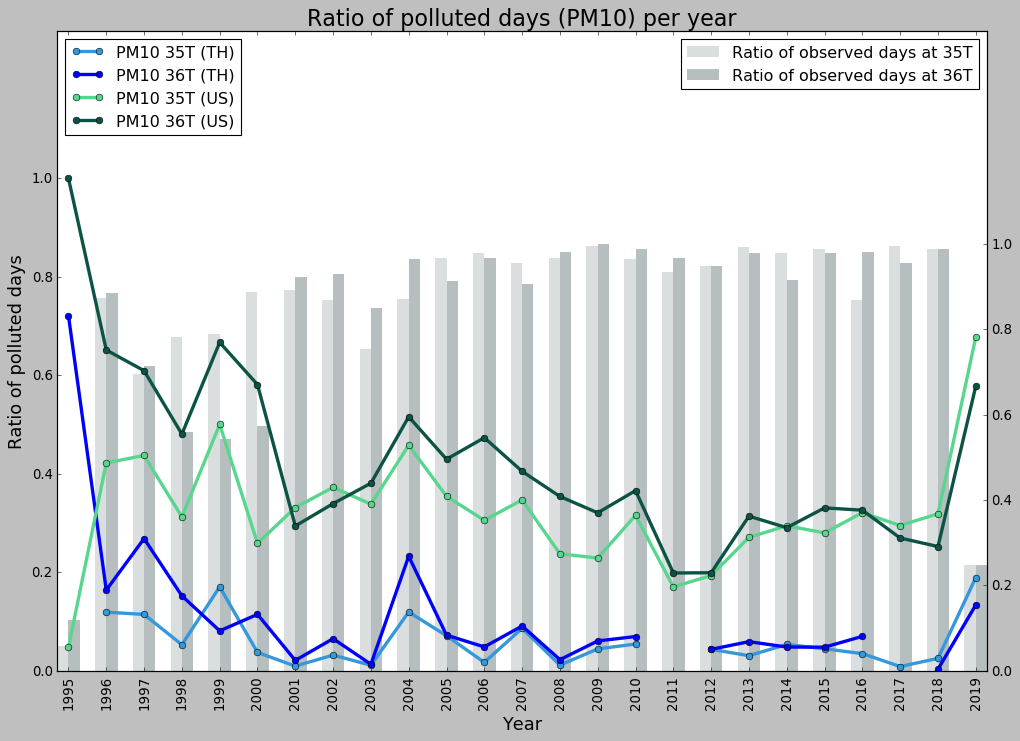

In [1059]:
year_ls = list(PM_df['year'])
#color_ls = ['grey']*len(year_ls)
#color_ls[10]='red'

plt.rcParams['figure.figsize'] = [15, 10] # enlarge the default plotting size

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# Plot bars first
w = 0.3
ax1.bar([x-w/2 for x in year_ls],PM_df['PM10_35T_data_R'],width=w,color='#CCD1D1',alpha=0.7,align='center',edgecolor = "none",label="Ratio of observed days at 35T")
ax1.bar([x+w/2 for x in year_ls],PM_df['PM10_36T_data_R'],width=w,color='#99A3A4',alpha=0.7,align='center',edgecolor = "none",label="Ratio of observed days at 36T")

# Format axis labels and ticks
ax1.xaxis.set_ticks(year_ls)
ax1.set_xticklabels(year_ls,rotation=90, fontsize=s)
ax1.set_ylim(0, 1.5)
ax1.yaxis.set_ticks([0,0.2,0.4,0.6,0.8,1.0])
ax1.yaxis.tick_right()

#ax1.yaxis.set_label_position("right")
#ax1.bar(year_ls,PM_df['PM10_36T_data_R'],color='b',alpha=0.2)


# Plot line charts
ax2.plot(year_ls, PM_df['PM10_35T_th_R'], marker="o", color='#3498DB', linewidth=3, label='PM10 35T (TH)')
ax2.plot(year_ls, PM_df['PM10_36T_th_R'], marker="o", color='b', linewidth=3, label='PM10 36T (TH)')
ax2.plot(year_ls, PM_df['PM10_35T_us_R'], marker="o", color='#58D68D', linewidth=3, label='PM10 35T (US)')
ax2.plot(year_ls, PM_df['PM10_36T_us_R'], marker="o", color='#0B5345', linewidth=3, label='PM10 36T (US)')
ax2.yaxis.tick_left()
ax2.yaxis.set_label_position("left")
ax2.set_ylim(0, 1.3)
ax2.yaxis.set_ticks([0,0.2,0.4,0.6,0.8,1.0])

# Add legend
ax2.legend(loc=2)
ax1.legend(loc=1)

ax2.set_ylabel('Ratio of polluted days',fontsize = m)
ax1.set_xlabel("Year", fontsize=m)
plt.title('Ratio of polluted days (PM10) per year', loc='Center', fontsize=l, fontweight=0)


plt.savefig(figure_path+'figure2.png',dpi=300)
plt.show()

## 2.3 Total pollutated days per year for PM2.5 (Figure 3)

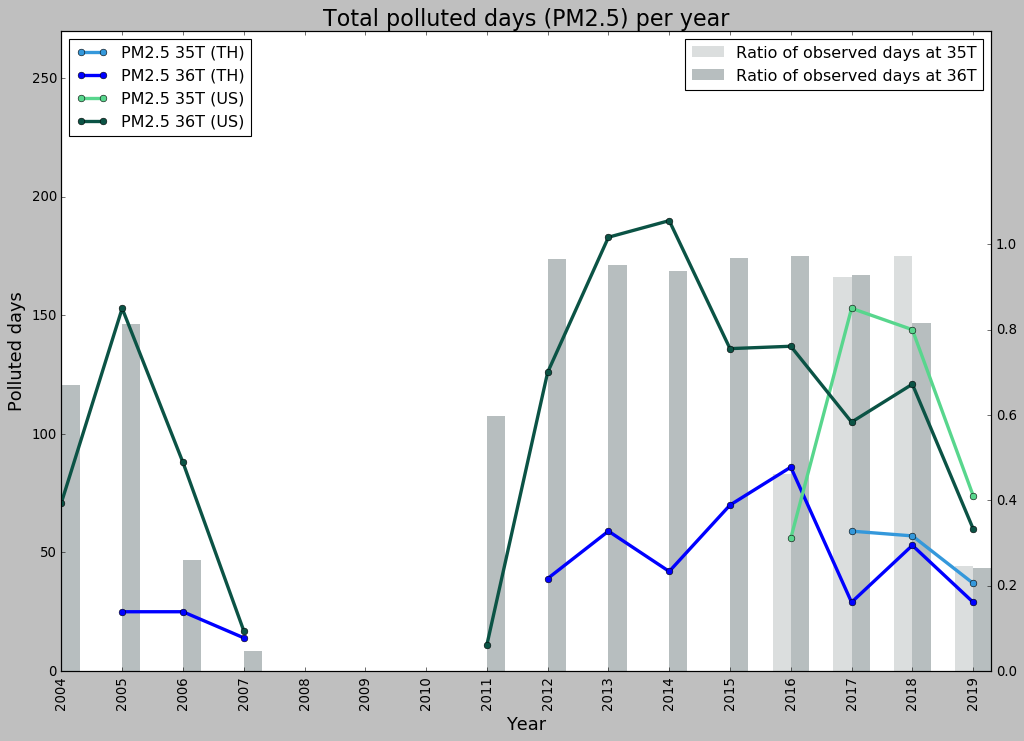

In [1060]:
year_ls = list(PM_df['year'])
#color_ls = ['grey']*len(year_ls)
#color_ls[10]='red'

plt.rcParams['figure.figsize'] = [15, 10] # enlarge the default plotting size

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# Plot bars first
w = 0.3
ax1.bar([x-w/2 for x in year_ls],PM_df['PM25_35T_data_R'],width=w,color='#CCD1D1',alpha=0.7,align='center',edgecolor = "none",label="Ratio of observed days at 35T")
ax1.bar([x+w/2 for x in year_ls],PM_df['PM25_36T_data_R'],width=w,color='#99A3A4',alpha=0.7,align='center',edgecolor = "none",label="Ratio of observed days at 36T")

# Format axis labels and ticks
ax1.xaxis.set_ticks(year_ls)
ax1.set_xticklabels(year_ls,rotation=90, fontsize=s)
ax1.set_ylim(0, 1.5)
ax1.yaxis.set_ticks([0,0.2,0.4,0.6,0.8,1.0])
ax1.yaxis.tick_right()

#ax1.yaxis.set_label_position("right")
#ax1.bar(year_ls,PM_df['PM10_36T_data_R'],color='b',alpha=0.2)


# Plot line charts
ax2.plot(year_ls, PM_df['PM25_35T_th'], marker="o", color='#3498DB', linewidth=3, label='PM2.5 35T (TH)')
ax2.plot(year_ls, PM_df['PM25_36T_th'], marker="o", color='b', linewidth=3, label='PM2.5 36T (TH)')
ax2.plot(year_ls, PM_df['PM25_35T_us'], marker="o", color='#58D68D', linewidth=3, label='PM2.5 35T (US)')
ax2.plot(year_ls, PM_df['PM25_36T_us'], marker="o", color='#0B5345', linewidth=3, label='PM2.5 36T (US)')
ax2.yaxis.tick_left()
ax2.yaxis.set_label_position("left")
ax2.set_ylim(0, 270)

# Add legend
ax2.legend(loc=2)
ax1.legend(loc=1)

ax2.set_ylabel('Polluted days',fontsize = m)
ax1.set_xlabel("Year", fontsize=m)
plt.title('Total polluted days (PM2.5) per year', loc='Center', fontsize=l, fontweight=0)
plt.savefig(figure_path+'figure3.png',dpi=300)
plt.show()

## 2.3 Ratio of pollutated days per year for PM2.5 (Figure 4)

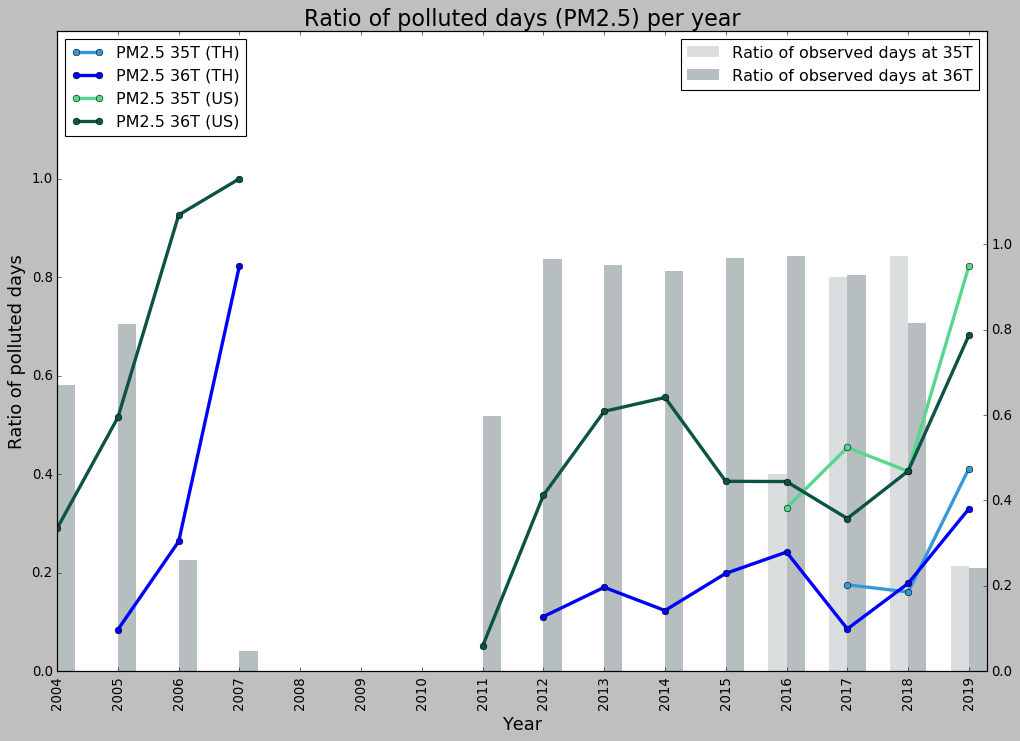

In [1061]:
plt.rcParams['figure.figsize'] = [15, 10] # enlarge the default plotting size

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# Plot bars first
w = 0.3
ax1.bar([x-w/2 for x in year_ls],PM_df['PM25_35T_data_R'],width=w,color='#CCD1D1',alpha=0.7,align='center',edgecolor = "none",label="Ratio of observed days at 35T")
ax1.bar([x+w/2 for x in year_ls],PM_df['PM25_36T_data_R'],width=w,color='#99A3A4',alpha=0.7,align='center',edgecolor = "none",label="Ratio of observed days at 36T")

# Format axis labels and ticks
ax1.xaxis.set_ticks(year_ls)
ax1.set_xticklabels(year_ls,rotation=90, fontsize=s)
ax1.set_ylim(0, 1.5)
ax1.yaxis.set_ticks([0,0.2,0.4,0.6,0.8,1.0])
ax1.yaxis.tick_right()

#ax1.yaxis.set_label_position("right")
#ax1.bar(year_ls,PM_df['PM10_36T_data_R'],color='b',alpha=0.2)


# Plot line charts
ax2.plot(year_ls, PM_df['PM25_35T_th_R'], marker="o", color='#3498DB', linewidth=3, label='PM2.5 35T (TH)')
ax2.plot(year_ls, PM_df['PM25_36T_th_R'], marker="o", color='b', linewidth=3, label='PM2.5 36T (TH)')
ax2.plot(year_ls, PM_df['PM25_35T_us_R'], marker="o", color='#58D68D', linewidth=3, label='PM2.5 35T (US)')
ax2.plot(year_ls, PM_df['PM25_36T_us_R'], marker="o", color='#0B5345', linewidth=3, label='PM2.5 36T (US)')
ax2.yaxis.tick_left()
ax2.yaxis.set_label_position("left")
ax2.set_ylim(0, 1.3)
ax2.yaxis.set_ticks([0,0.2,0.4,0.6,0.8,1.0])

# Add legend
ax2.legend(loc=2)
ax1.legend(loc=1)

ax2.set_ylabel('Ratio of polluted days',fontsize = m)
ax1.set_xlabel("Year", fontsize=m)
plt.title('Ratio of polluted days (PM2.5) per year', loc='Center', fontsize=l, fontweight=0)


plt.savefig(figure_path+'figure4.png',dpi=300)
plt.show()

# 3. Montly Analysis

Re-organize the monthly data

In [1062]:
# Plot PM 10 bar chart
#x_pos_35T=np.arange(len(year_ls_pm10))
#x_pos_36T=np.arange(len(year_ls_pm10)) + w

# Count pollutated days regarding PM10
PM10_36T_pl_th_m = PM10_36T_pl_th.groupby(PM10_36T_pl_th['date_time'].dt.month)['date_time'].count()
PM10_35T_pl_th_m = PM10_35T_pl_th.groupby(PM10_35T_pl_th['date_time'].dt.month)['date_time'].count()
PM10_36T_pl_us_m = PM10_36T_pl_us.groupby(PM10_36T_pl_us['date_time'].dt.month)['date_time'].count()
PM10_35T_pl_us_m = PM10_35T_pl_us.groupby(PM10_35T_pl_us['date_time'].dt.month)['date_time'].count()

# Count pollutated days regarding PM2.5
PM25_36T_pl_th_m = PM25_36T_pl_th.groupby(PM25_36T_pl_th['date_time'].dt.month)['date_time'].count()
PM25_35T_pl_th_m = PM25_35T_pl_th.groupby(PM25_35T_pl_th['date_time'].dt.month)['date_time'].count()
PM25_36T_pl_us_m = PM25_36T_pl_us.groupby(PM25_36T_pl_us['date_time'].dt.month)['date_time'].count()
PM25_35T_pl_us_m = PM25_35T_pl_us.groupby(PM25_35T_pl_us['date_time'].dt.month)['date_time'].count()

# Count days with data
PM10_36T_all_m = PM10_36T_all.groupby(PM10_36T_all['date_time'].dt.month)['date_time'].count()
PM10_35T_all_m = PM10_35T_all.groupby(PM10_35T_all['date_time'].dt.month)['date_time'].count()
PM25_36T_all_m = PM25_36T_all.groupby(PM25_36T_all['date_time'].dt.month)['date_time'].count()
PM25_35T_all_m = PM25_35T_all.groupby(PM25_35T_all['date_time'].dt.month)['date_time'].count()

PM_df_m = pd.concat([PM10_36T_pl_th_m,PM10_35T_pl_th_m,PM10_36T_pl_us_m,PM10_35T_pl_us_m,PM25_36T_pl_th_m,PM25_35T_pl_th_m,PM25_36T_pl_us_m,PM25_35T_pl_us_m,PM10_36T_all_m,PM10_35T_all_m,PM25_36T_all_m,PM25_35T_all_m], axis=1)
PM_df_m.columns=["PM10_36T_th","PM10_35T_th","PM10_36T_us","PM10_35T_us","PM25_36T_th","PM25_35T_th","PM25_36T_us","PM25_35T_us","PM10_36T_all","PM10_35T_all","PM25_36T_all","PM25_35T_all"]
PM_df_m = PM_df_m.reset_index().rename(columns={'date_time':'month'})

# Calculate ratio of polluted days per month
PM_df_m['PM10_36T_th_R']=PM_df_m['PM10_36T_th']/PM_df_m['PM10_36T_all']
PM_df_m['PM10_35T_th_R']=PM_df_m['PM10_35T_th']/PM_df_m['PM10_35T_all']
PM_df_m['PM10_36T_us_R']=PM_df_m['PM10_36T_us']/PM_df_m['PM10_36T_all']
PM_df_m['PM10_35T_us_R']=PM_df_m['PM10_35T_us']/PM_df_m['PM10_35T_all']

PM_df_m['PM25_36T_th_R']=PM_df_m['PM25_36T_th']/PM_df_m['PM25_36T_all']
PM_df_m['PM25_35T_th_R']=PM_df_m['PM25_35T_th']/PM_df_m['PM25_35T_all']
PM_df_m['PM25_36T_us_R']=PM_df_m['PM25_36T_us']/PM_df_m['PM25_36T_all']
PM_df_m['PM25_35T_us_R']=PM_df_m['PM25_35T_us']/PM_df_m['PM25_35T_all']

Calculate ratios of observed days per month

In [1083]:
PM_df_m['days_in_month'] = [775,704,775,750,775,750,775,775,750,775,750,775]

PM_df_m['PM10_36T_data_R'] = PM_df_m['PM10_36T_all']/ PM_df_m['days_in_month']
PM_df_m['PM10_35T_data_R'] = PM_df_m['PM10_35T_all']/ PM_df_m['days_in_month']
PM_df_m['PM25_36T_data_R'] = PM_df_m['PM25_36T_all']/ PM_df_m['days_in_month']
PM_df_m['PM25_35T_data_R'] = PM_df_m['PM25_35T_all']/ PM_df_m['days_in_month']

## 3.1 Total pollutated days per month PM10 (Figure 5)

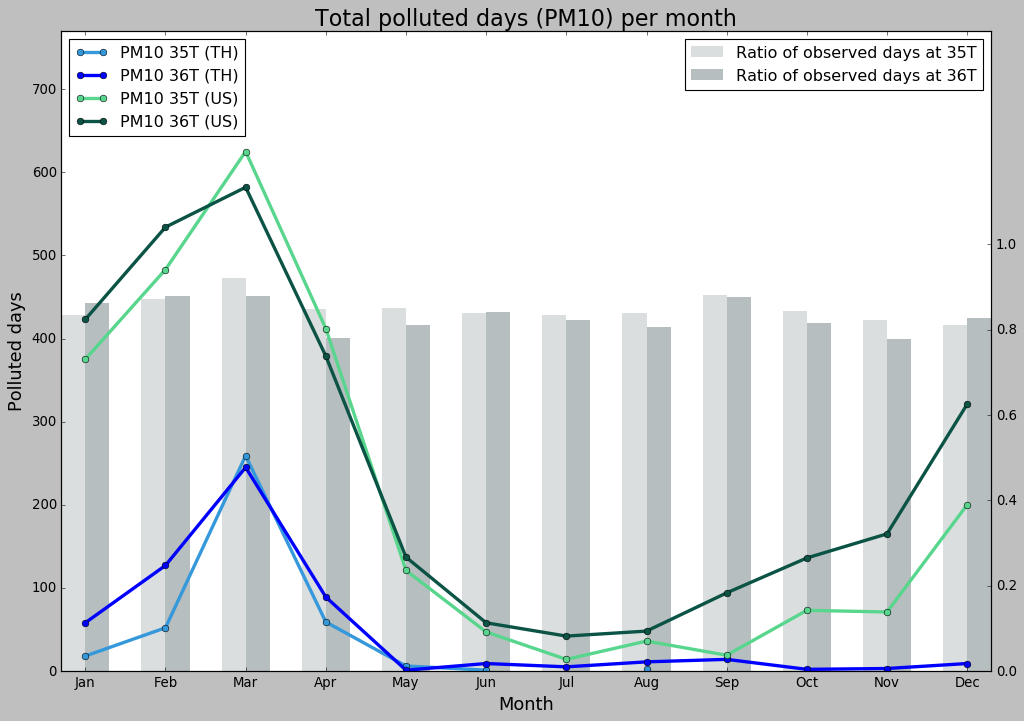

In [1084]:
month_ls_m = list(PM_df_m['month'])
month_ls_m_tx = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

plt.rcParams['figure.figsize'] = [15, 10] # enlarge the default plotting size

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# Plot bars first
w = 0.3
ax1.bar([x-w/2 for x in month_ls_m],PM_df_m['PM10_35T_data_R'],width=w,color='#CCD1D1',alpha=0.7,align='center',edgecolor = "none",label="Ratio of observed days at 35T")
ax1.bar([x+w/2 for x in month_ls_m],PM_df_m['PM10_36T_data_R'],width=w,color='#99A3A4',alpha=0.7,align='center',edgecolor = "none",label="Ratio of observed days at 36T")

# Format axis labels and ticks
ax1.xaxis.set_ticks(month_ls_m)
ax1.set_xticklabels(month_ls_m_tx,fontsize=s)
ax1.set_ylim(0, 1.5)
ax1.yaxis.set_ticks([0,0.2,0.4,0.6,0.8,1.0])
ax1.yaxis.tick_right()

#ax1.yaxis.set_label_position("right")
#ax1.bar(year_ls,PM_df['PM10_36T_data_R'],color='b',alpha=0.2)


# Plot line charts
ax2.plot(month_ls_m, PM_df_m['PM10_35T_th'], marker="o", color='#3498DB', linewidth=3, label='PM10 35T (TH)')
ax2.plot(month_ls_m, PM_df_m['PM10_36T_th'], marker="o", color='b', linewidth=3, label='PM10 36T (TH)')
ax2.plot(month_ls_m, PM_df_m['PM10_35T_us'], marker="o", color='#58D68D', linewidth=3, label='PM10 35T (US)')
ax2.plot(month_ls_m, PM_df_m['PM10_36T_us'], marker="o", color='#0B5345', linewidth=3, label='PM10 36T (US)')
ax2.yaxis.tick_left()
ax2.yaxis.set_label_position("left")
ax2.set_ylim(0, 770)

# Add legend
ax2.legend(loc=2)
ax1.legend(loc=1)

ax2.set_ylabel('Polluted days',fontsize = m)
ax1.set_xlabel("Month", fontsize=m)
plt.title('Total polluted days (PM10) per month', loc='Center', fontsize=l, fontweight=0)


plt.savefig(figure_path+'figure5.png',dpi=300)
plt.show()

## 3.2 Total pollutated days per month for PM2.5 (Figure 6)

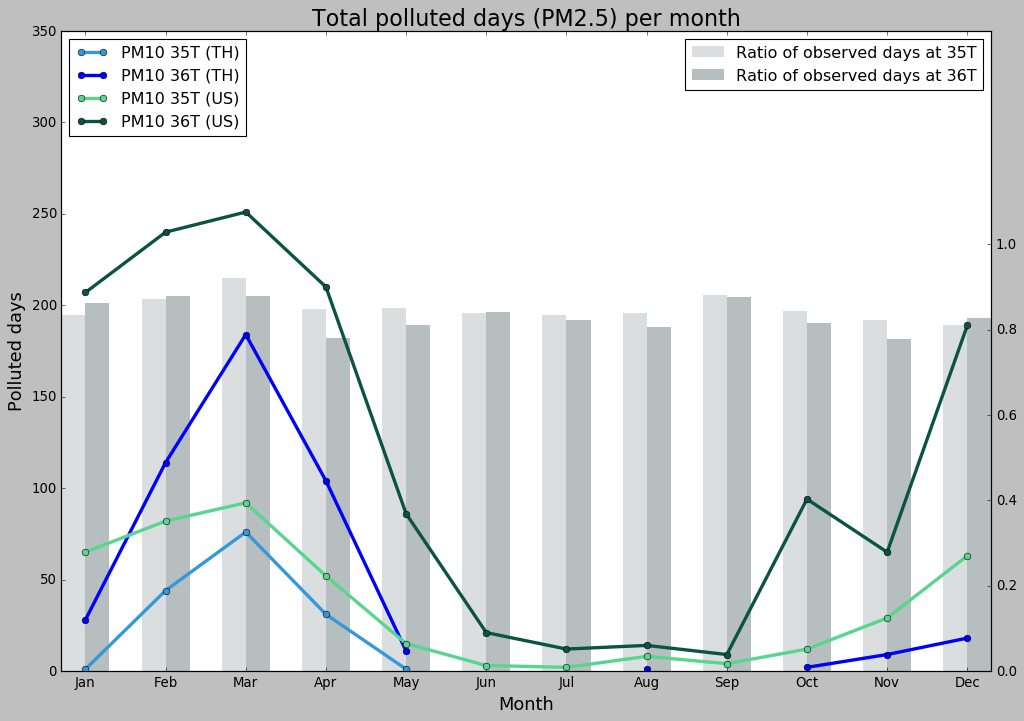

In [1065]:
month_ls_m = list(PM_df_m['month'])
month_ls_m_tx = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

plt.rcParams['figure.figsize'] = [15, 10] # enlarge the default plotting size

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# Plot bars first
w = 0.3
ax1.bar([x-w/2 for x in month_ls_m],PM_df_m['PM10_35T_data_R'],width=w,color='#CCD1D1',alpha=0.7,align='center',edgecolor = "none",label="Ratio of observed days at 35T")
ax1.bar([x+w/2 for x in month_ls_m],PM_df_m['PM10_36T_data_R'],width=w,color='#99A3A4',alpha=0.7,align='center',edgecolor = "none",label="Ratio of observed days at 36T")

# Format axis labels and ticks
ax1.xaxis.set_ticks(month_ls_m)
ax1.set_xticklabels(month_ls_m_tx,fontsize=s)
ax1.set_ylim(0, 1.5)
ax1.yaxis.set_ticks([0,0.2,0.4,0.6,0.8,1.0])
ax1.yaxis.tick_right()

#ax1.yaxis.set_label_position("right")
#ax1.bar(year_ls,PM_df['PM10_36T_data_R'],color='b',alpha=0.2)


# Plot line charts
ax2.plot(month_ls_m, PM_df_m['PM25_35T_th'], marker="o", color='#3498DB', linewidth=3, label='PM10 35T (TH)')
ax2.plot(month_ls_m, PM_df_m['PM25_36T_th'], marker="o", color='b', linewidth=3, label='PM10 36T (TH)')
ax2.plot(month_ls_m, PM_df_m['PM25_35T_us'], marker="o", color='#58D68D', linewidth=3, label='PM10 35T (US)')
ax2.plot(month_ls_m, PM_df_m['PM25_36T_us'], marker="o", color='#0B5345', linewidth=3, label='PM10 36T (US)')
ax2.yaxis.tick_left()
ax2.yaxis.set_label_position("left")
ax2.set_ylim(0, 350)

# Add legend
ax2.legend(loc=2)
ax1.legend(loc=1)

ax2.set_ylabel('Polluted days',fontsize = m)
ax1.set_xlabel("Month", fontsize=m)
plt.title('Total polluted days (PM2.5) per month', loc='Center', fontsize=l, fontweight=0)



plt.savefig(figure_path+'figure6.png',dpi=300)
plt.show()

## 3.3 Ratio of pollutated days per month for PM10 (Figure 7)

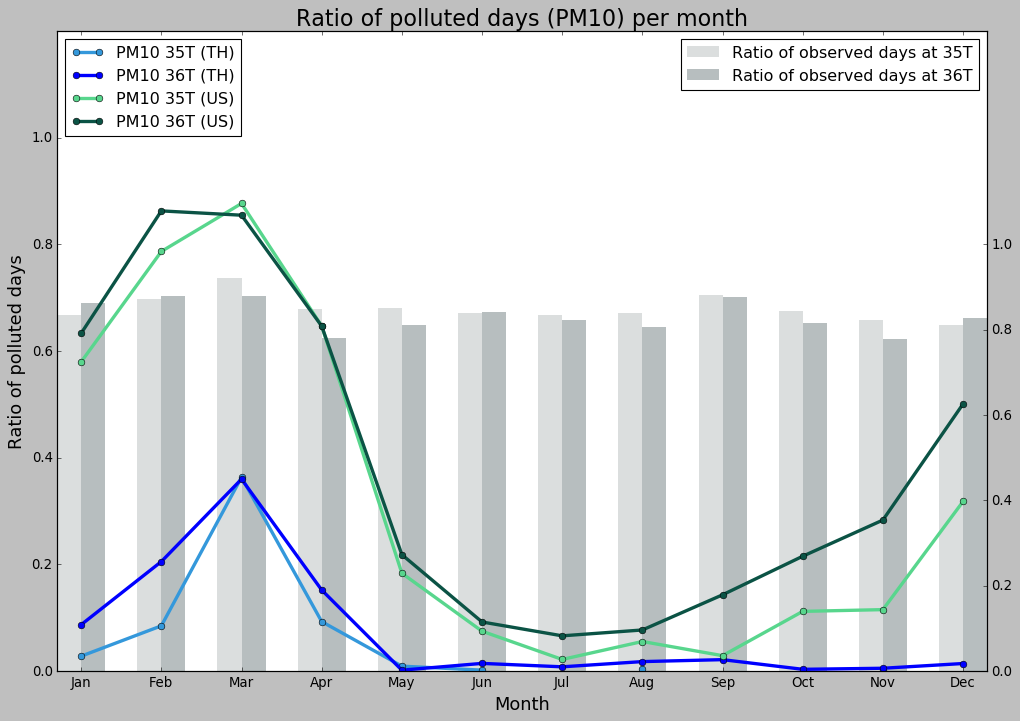

In [1066]:
plt.rcParams['figure.figsize'] = [15, 10] # enlarge the default plotting size

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# Plot bars first
w = 0.3
ax1.bar([x-w/2 for x in month_ls_m],PM_df_m['PM10_35T_data_R'],width=w,color='#CCD1D1',alpha=0.7,align='center',edgecolor = "none",label="Ratio of observed days at 35T")
ax1.bar([x+w/2 for x in month_ls_m],PM_df_m['PM10_36T_data_R'],width=w,color='#99A3A4',alpha=0.7,align='center',edgecolor = "none",label="Ratio of observed days at 36T")

# Format axis labels and ticks
ax1.xaxis.set_ticks(month_ls_m)
ax1.set_xticklabels(month_ls_m_tx,fontsize=s)
ax1.set_ylim(0, 1.5)
ax1.yaxis.set_ticks([0,0.2,0.4,0.6,0.8,1.0])
ax1.yaxis.tick_right()

#ax1.yaxis.set_label_position("right")
#ax1.bar(year_ls,PM_df['PM10_36T_data_R'],color='b',alpha=0.2)


# Plot line charts
ax2.plot(month_ls_m, PM_df_m['PM10_35T_th_R'], marker="o", color='#3498DB', linewidth=3, label='PM10 35T (TH)')
ax2.plot(month_ls_m, PM_df_m['PM10_36T_th_R'], marker="o", color='b', linewidth=3, label='PM10 36T (TH)')
ax2.plot(month_ls_m, PM_df_m['PM10_35T_us_R'], marker="o", color='#58D68D', linewidth=3, label='PM10 35T (US)')
ax2.plot(month_ls_m, PM_df_m['PM10_36T_us_R'], marker="o", color='#0B5345', linewidth=3, label='PM10 36T (US)')
ax2.yaxis.tick_left()
ax2.yaxis.set_label_position("left")
ax2.set_ylim(0, 1.2)
ax2.yaxis.set_ticks([0,0.2,0.4,0.6,0.8,1.0])

# Add legend
ax2.legend(loc=2)
ax1.legend(loc=1)

ax2.set_ylabel('Ratio of polluted days',fontsize = m)
ax1.set_xlabel("Month", fontsize=m)
plt.title('Ratio of polluted days (PM10) per month', loc='Center', fontsize=l, fontweight=0)

plt.savefig(figure_path+'figure7.png',dpi=300)
plt.show()

## 3.4 Ratio of pollutated days per month for PM2.5 (Figure 8)

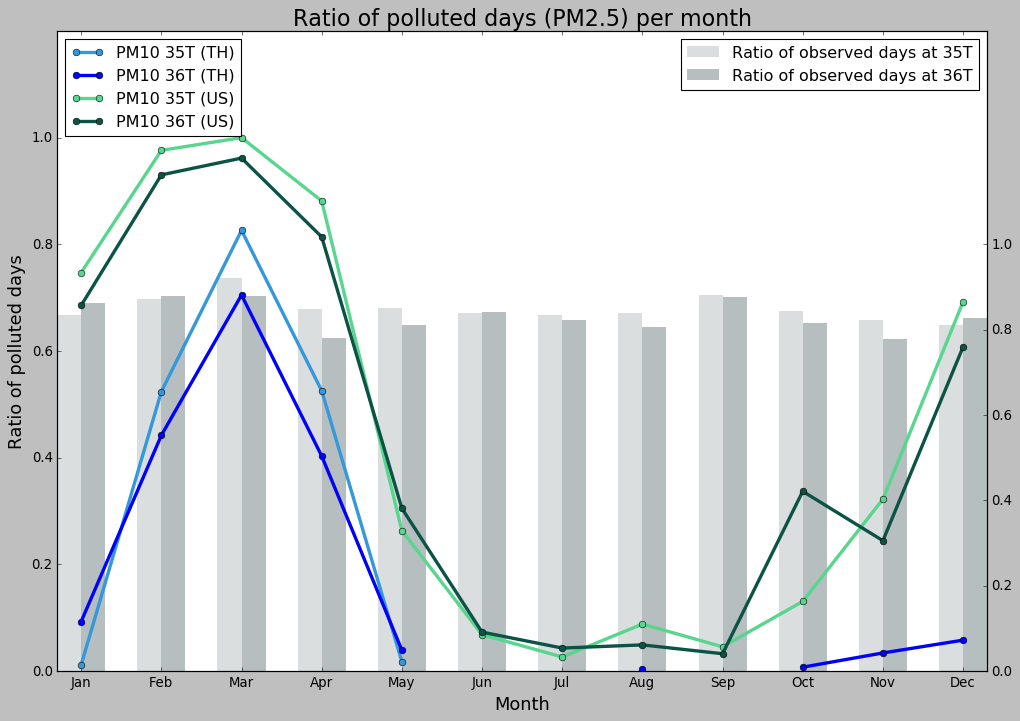

In [1067]:
plt.rcParams['figure.figsize'] = [15, 10] # enlarge the default plotting size

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# Plot bars first
w = 0.3
ax1.bar([x-w/2 for x in month_ls_m],PM_df_m['PM10_35T_data_R'],width=w,color='#CCD1D1',alpha=0.7,align='center',edgecolor = "none",label="Ratio of observed days at 35T")
ax1.bar([x+w/2 for x in month_ls_m],PM_df_m['PM10_36T_data_R'],width=w,color='#99A3A4',alpha=0.7,align='center',edgecolor = "none",label="Ratio of observed days at 36T")

# Format axis labels and ticks
ax1.xaxis.set_ticks(month_ls_m)
ax1.set_xticklabels(month_ls_m_tx,fontsize=s)
ax1.set_ylim(0, 1.5)
ax1.yaxis.set_ticks([0,0.2,0.4,0.6,0.8,1.0])
ax1.yaxis.tick_right()

#ax1.yaxis.set_label_position("right")
#ax1.bar(year_ls,PM_df['PM10_36T_data_R'],color='b',alpha=0.2)


# Plot line charts
ax2.plot(month_ls_m, PM_df_m['PM25_35T_th_R'], marker="o", color='#3498DB', linewidth=3, label='PM10 35T (TH)')
ax2.plot(month_ls_m, PM_df_m['PM25_36T_th_R'], marker="o", color='b', linewidth=3, label='PM10 36T (TH)')
ax2.plot(month_ls_m, PM_df_m['PM25_35T_us_R'], marker="o", color='#58D68D', linewidth=3, label='PM10 35T (US)')
ax2.plot(month_ls_m, PM_df_m['PM25_36T_us_R'], marker="o", color='#0B5345', linewidth=3, label='PM10 36T (US)')
ax2.yaxis.tick_left()
ax2.yaxis.set_label_position("left")
ax2.set_ylim(0, 1.2)
ax2.yaxis.set_ticks([0,0.2,0.4,0.6,0.8,1.0])

# Add legend
ax2.legend(loc=2)
ax1.legend(loc=1)

ax2.set_ylabel('Ratio of polluted days',fontsize = m)
ax1.set_xlabel("Month", fontsize=m)
plt.title('Ratio of polluted days (PM2.5) per month', loc='Center', fontsize=l, fontweight=0)


plt.savefig(figure_path+'figure8.png',dpi=300)
plt.show()

# 5. Change of ratio of polluted days in different years

Organize the data

In [1068]:
# Count polluted days 
PM10_36T_th_my = PM10_36T_pl_th.groupby([PM10_36T_pl_th['date_time'].dt.month,PM10_36T_pl_th['date_time'].dt.year])['date_time'].count()
PM10_35T_th_my = PM10_35T_pl_th.groupby([PM10_35T_pl_th['date_time'].dt.month,PM10_35T_pl_th['date_time'].dt.year])['date_time'].count()
PM25_36T_th_my = PM25_36T_pl_th.groupby([PM25_36T_pl_th['date_time'].dt.month,PM25_36T_pl_th['date_time'].dt.year])['date_time'].count()
PM25_35T_th_my = PM25_35T_pl_th.groupby([PM25_35T_pl_th['date_time'].dt.month,PM25_35T_pl_th['date_time'].dt.year])['date_time'].count()

PM10_36T_us_my = PM10_36T_pl_us.groupby([PM10_36T_pl_us['date_time'].dt.month,PM10_36T_pl_us['date_time'].dt.year])['date_time'].count()
PM10_35T_us_my = PM10_35T_pl_us.groupby([PM10_35T_pl_us['date_time'].dt.month,PM10_35T_pl_us['date_time'].dt.year])['date_time'].count()
PM25_36T_us_my = PM25_36T_pl_us.groupby([PM25_36T_pl_us['date_time'].dt.month,PM25_36T_pl_us['date_time'].dt.year])['date_time'].count()
PM25_35T_us_my = PM25_35T_pl_us.groupby([PM25_35T_pl_us['date_time'].dt.month,PM25_35T_pl_us['date_time'].dt.year])['date_time'].count()

# Count all measured days 
PM10_36T_all_my = PM10_36T_all.groupby([PM10_36T_all['date_time'].dt.month,PM10_36T_all['date_time'].dt.year])['date_time'].count()
PM10_35T_all_my = PM10_35T_all.groupby([PM10_35T_all['date_time'].dt.month,PM10_35T_all['date_time'].dt.year])['date_time'].count()
PM25_36T_all_my = PM25_36T_all.groupby([PM25_36T_all['date_time'].dt.month,PM25_36T_all['date_time'].dt.year])['date_time'].count()
PM25_35T_all_my = PM25_35T_all.groupby([PM25_35T_all['date_time'].dt.month,PM25_35T_all['date_time'].dt.year])['date_time'].count()

In [1069]:
# Convert the counts to data frame
PM10_36T_th_my = PM10_36T_th_my.rename_axis(["month",'year'], axis="index")
PM10_35T_th_my = PM10_35T_th_my.rename_axis(["month",'year'], axis="index")
PM25_36T_th_my = PM25_36T_th_my.rename_axis(["month",'year'], axis="index")
PM25_35T_th_my = PM25_35T_th_my.rename_axis(["month",'year'], axis="index")

PM10_36T_us_my = PM10_36T_us_my.rename_axis(["month",'year'], axis="index")
PM10_35T_us_my = PM10_35T_us_my.rename_axis(["month",'year'], axis="index")
PM25_36T_us_my = PM25_36T_us_my.rename_axis(["month",'year'], axis="index")
PM25_35T_us_my = PM25_35T_us_my.rename_axis(["month",'year'], axis="index")

PM10_36T_all_my = PM10_36T_all_my.rename_axis(["month",'year'], axis="index")
PM10_35T_all_my = PM10_35T_all_my.rename_axis(["month",'year'], axis="index")
PM25_36T_all_my = PM25_36T_all_my.rename_axis(["month",'year'], axis="index")
PM25_35T_all_my = PM25_35T_all_my.rename_axis(["month",'year'], axis="index")

In [1070]:
PM_df_my = pd.concat([PM10_36T_th_my,PM10_35T_th_my,PM10_36T_us_my,PM10_35T_us_my,PM25_36T_th_my,PM25_35T_th_my,PM25_36T_us_my,PM25_35T_us_my,PM10_36T_all_my,PM10_35T_all_my,PM25_36T_all_my,PM25_35T_all_my], axis=1)
PM_df_my.columns=["PM10_36T_th","PM10_35T_th","PM10_36T_us","PM10_35T_us","PM25_36T_th","PM25_35T_th","PM25_36T_us","PM25_35T_us","PM10_36T_all","PM10_35T_all","PM25_36T_all","PM25_35T_all"]
PM_df_my = PM_df_my.reset_index().fillna(0)

PM_df_my['PM10_36T_th_R']=PM_df_my['PM10_36T_th']/PM_df_my['PM10_36T_all']
PM_df_my['PM10_35T_th_R']=PM_df_my['PM10_35T_th']/PM_df_my['PM10_35T_all']
PM_df_my['PM10_36T_us_R']=PM_df_my['PM10_36T_us']/PM_df_my['PM10_36T_all']
PM_df_my['PM10_35T_us_R']=PM_df_my['PM10_35T_us']/PM_df_my['PM10_35T_all']

PM_df_my['PM25_36T_th_R']=PM_df_my['PM25_36T_th']/PM_df_my['PM25_36T_all']
PM_df_my['PM25_35T_th_R']=PM_df_my['PM25_35T_th']/PM_df_my['PM25_35T_all']
PM_df_my['PM25_36T_us_R']=PM_df_my['PM25_36T_us']/PM_df_my['PM25_36T_all']
PM_df_my['PM25_35T_us_R']=PM_df_my['PM25_35T_us']/PM_df_my['PM25_35T_all']

## 5.1 Monthly ratio of pollutated days per year for PM10 at Station 35T (Figure 9)

In [1071]:
PM_df_my2 = PM_df_my[(PM_df_my['month']>=2) & (PM_df_my['month']<=3)]

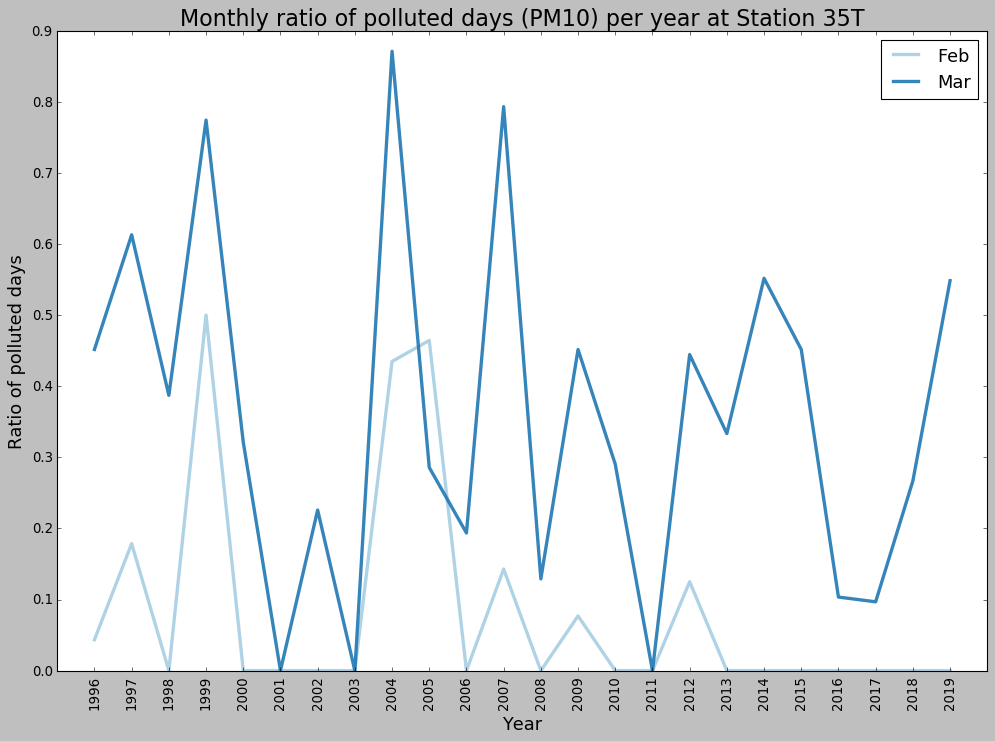

In [1072]:
year_ls = list(PM_df_my2['year'].unique())
year_ls.sort()

# style
plt.style.use('classic')
plt.rcParams['axes.facecolor']='white'
plt.rcParams['figure.figsize'] = [15, 10] # enlarge the default plotting size

# create a color palette
palette = plt.get_cmap('Paired')
 
# multiple line plot
num=0
w=0.3
for mon in list(PM_df_my2['month'].unique()):
    y = PM_df_my2[PM_df_my2['month'] == mon]['PM10_35T_th_R']
    x = PM_df_my2[PM_df_my2['month'] == mon]['year']

    plt.plot(x, y, marker='', color=palette(num), linewidth=3, alpha=0.9, label=calendar.month_abbr[mon])
    num+=1

    
# Add legend
plt.legend(loc='upper right',fontsize=m)

plt.yticks(fontsize=s)
plt.xticks(year_ls, year_ls,rotation=90,fontsize=s)
plt.ylabel('Ratio of polluted days',fontsize = m)
plt.xlabel('Year',fontsize = m)
plt.title('Monthly ratio of polluted days (PM10) per year at Station 35T', loc='Center', fontsize=l, fontweight=0)

plt.savefig(figure_path+'figure9.png',dpi=300)
plt.show()

## 5.1 Monthly ratio of pollutated days per year for PM10 at Station 36T (Figure 10)

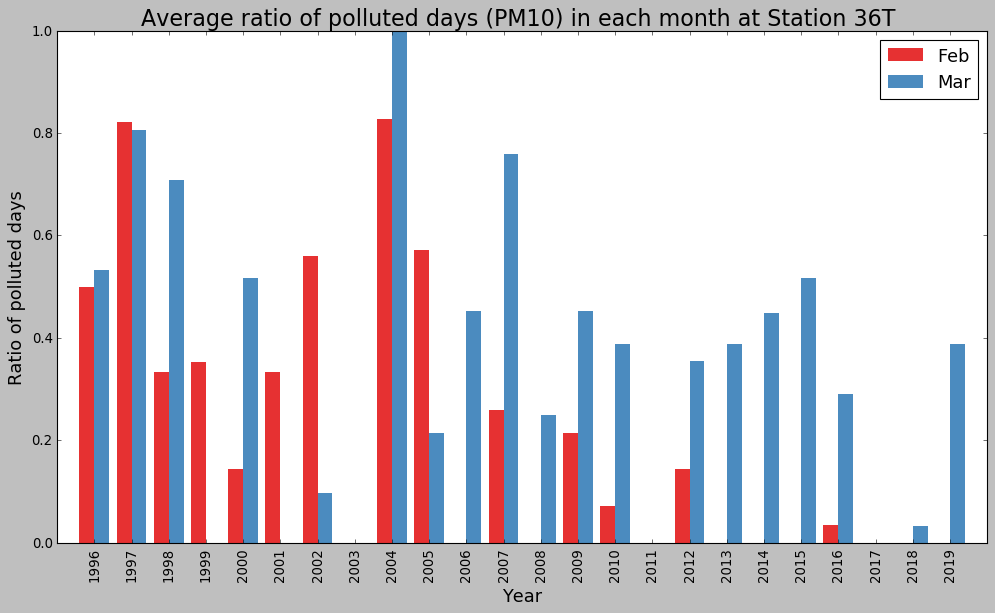

In [1086]:
year_ls = list(PM_df_my2['year'].unique())
year_ls.sort()

# style
plt.style.use('classic')
plt.rcParams['axes.facecolor']='white'
plt.rcParams['figure.figsize'] = [15, 8] # enlarge the default plotting size

# create a color palette
palette = plt.get_cmap('Set1')
 
# multiple line plot
num=0
w=0.4
for mon in list(PM_df_my2['month'].unique()):
    y = PM_df_my2[PM_df_my2['month'] == mon]['PM10_36T_th_R']
    x = PM_df_my2[PM_df_my2['month'] == mon]['year']
    
    #plt.bar(x+(num-1)*w,y,color=palette(num),alpha=0.9,width=w,align='center',edgecolor = "none",label=calendar.month_abbr[mon])
    plt.bar(x+(num-1)*w+0.5*w,y,color=palette(num),alpha=0.9,width=w,align='center',edgecolor = "none",label=calendar.month_abbr[mon])

    num+=1

    
# Add legend
plt.legend(loc='upper right',fontsize=m)

plt.yticks(fontsize=s)
plt.xticks(year_ls, year_ls,rotation=90,fontsize=s)
plt.ylabel('Ratio of polluted days',fontsize = m)
plt.xlabel('Year',fontsize = m)
plt.title('Average ratio of polluted days (PM10) in each month at Station 36T ', loc='Center', fontsize=l, fontweight=0)

plt.savefig(figure_path+'figure10.png',dpi=300)
plt.show()

### Smoothed curves

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.


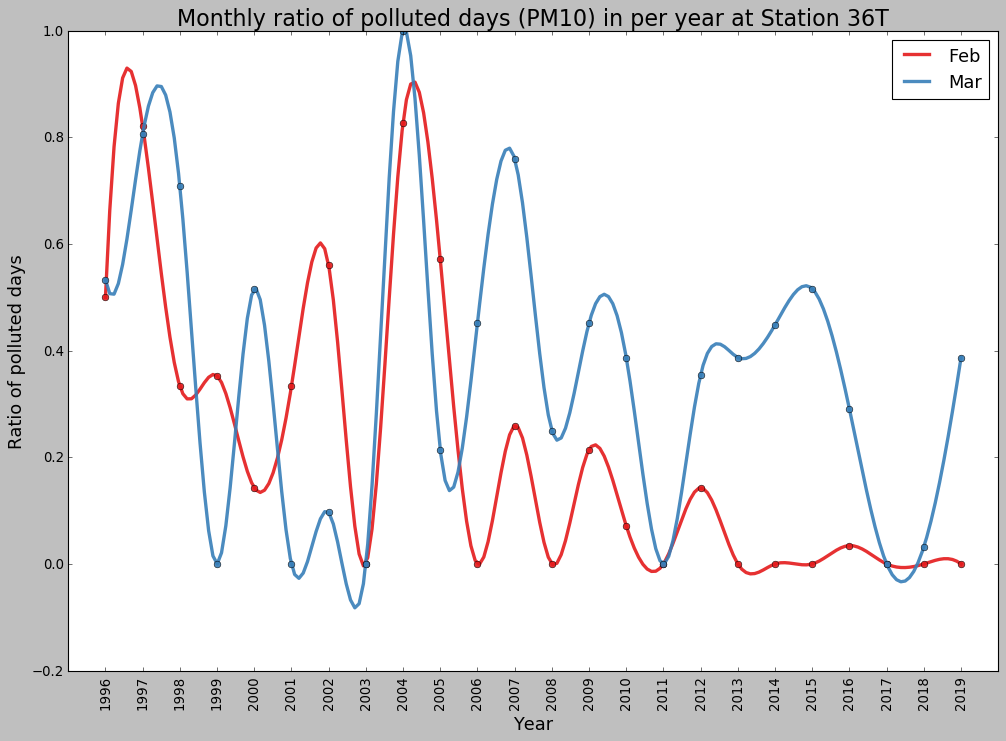

In [1074]:
year_ls = list(PM_df_my2['year'].unique())
year_ls.sort()

# style
plt.style.use('classic')
plt.rcParams['axes.facecolor']='white'
plt.rcParams['figure.figsize'] = [15, 10] # enlarge the default plotting size

# create a color palette
palette = plt.get_cmap('Set1')
 
# multiple line plot
num=0

for mon in list(PM_df_my2['month'].unique()):
    y = PM_df_my2[PM_df_my2['month'] == mon]['PM10_36T_th_R']
    x = PM_df_my2[PM_df_my2['month'] == mon]['year']
    
    xy = list(zip(x,y))
    xy = pd.DataFrame(xy, columns=['x','y'])
    xy=xy.dropna()
    
    x_smooth = np.linspace(xy['x'].min(), xy['x'].max(), 200)
    y_smooth = spline(list(xy['x']), list(xy['y']), x_smooth)

    #y_smooth = gaussian_filter1d(xy['y'], sigma=3)

    
    plt.plot(x_smooth, y_smooth, marker="", color=palette(num), linewidth=3, alpha=0.9, label=calendar.month_abbr[mon])
    plt.plot(x, y, marker="o", color=palette(num), linewidth=0, alpha=0.9)

    num+=1

    
# Add legend
plt.legend(loc='upper right',fontsize=m)

plt.yticks(fontsize=s)
plt.xticks(year_ls, year_ls,rotation=90,fontsize=s)
plt.ylabel('Ratio of polluted days',fontsize = m)
plt.xlabel('Year',fontsize = m)
plt.title('Monthly ratio of polluted days (PM10) in per year at Station 36T', loc='Center', fontsize=l, fontweight=0)

plt.savefig(figure_path+'figure11.png',dpi=300)
plt.show()

# 6. Number of consecutive polluted days

Create a new column to specify whether a day is polluted

In [1075]:
PM10_35T["polluted_us"]=PM10_35T["value"]>50
PM10_36T["polluted_us"]=PM10_36T["value"]>50

PM10_35T["polluted_th"]=PM10_35T["value"]>120
PM10_36T["polluted_th"]=PM10_36T["value"]>120

PM25_35T["polluted_us"]=PM25_35T["value"]>25
PM25_36T["polluted_us"]=PM25_36T["value"]>25

PM25_35T["polluted_th"]=PM25_35T["value"]>50
PM25_36T["polluted_th"]=PM25_36T["value"]>50

Create a column to count the number of consecutive polluted days

In [1076]:
year_ls = list(PM_df['year'])
for year in year_ls:

    PM10_35T.loc[PM10_35T['year'] == year, 'consecutive_us'] = PM10_35T[PM10_35T['year']==year].polluted_us.groupby((PM10_35T[PM10_35T['year']==year].polluted_us != PM10_35T[PM10_35T['year']==year].polluted_us.shift()).cumsum()).transform('size') * PM10_35T[PM10_35T['year']==year].polluted_us
    PM10_36T.loc[PM10_36T['year'] == year, 'consecutive_us'] = PM10_36T[PM10_36T['year']==year].polluted_us.groupby((PM10_36T[PM10_36T['year']==year].polluted_us != PM10_36T[PM10_36T['year']==year].polluted_us.shift()).cumsum()).transform('size') * PM10_36T[PM10_36T['year']==year].polluted_us
    
    PM10_35T.loc[PM10_35T['year'] == year, 'consecutive_th'] = PM10_35T[PM10_35T['year']==year].polluted_th.groupby((PM10_35T[PM10_35T['year']==year].polluted_th != PM10_35T[PM10_35T['year']==year].polluted_th.shift()).cumsum()).transform('size') * PM10_35T[PM10_35T['year']==year].polluted_th
    PM10_36T.loc[PM10_36T['year'] == year, 'consecutive_th'] = PM10_36T[PM10_36T['year']==year].polluted_th.groupby((PM10_36T[PM10_36T['year']==year].polluted_th != PM10_36T[PM10_36T['year']==year].polluted_th.shift()).cumsum()).transform('size') * PM10_36T[PM10_36T['year']==year].polluted_th

    PM25_35T.loc[PM25_35T['year'] == year, 'consecutive_us'] = PM25_35T[PM25_35T['year']==year].polluted_us.groupby((PM25_35T[PM25_35T['year']==year].polluted_us != PM25_35T[PM25_35T['year']==year].polluted_us.shift()).cumsum()).transform('size') * PM25_35T[PM25_35T['year']==year].polluted_us
    PM25_36T.loc[PM25_36T['year'] == year, 'consecutive_us'] = PM25_36T[PM25_36T['year']==year].polluted_us.groupby((PM25_36T[PM25_36T['year']==year].polluted_us != PM25_36T[PM25_36T['year']==year].polluted_us.shift()).cumsum()).transform('size') * PM25_36T[PM25_36T['year']==year].polluted_us

    PM25_35T.loc[PM25_35T['year'] == year, 'consecutive_th'] = PM25_35T[PM25_35T['year']==year].polluted_th.groupby((PM25_35T[PM25_35T['year']==year].polluted_th != PM25_35T[PM25_35T['year']==year].polluted_th.shift()).cumsum()).transform('size') * PM25_35T[PM25_35T['year']==year].polluted_th
    PM25_36T.loc[PM25_36T['year'] == year, 'consecutive_th'] = PM25_36T[PM25_36T['year']==year].polluted_th.groupby((PM25_36T[PM25_36T['year']==year].polluted_th != PM25_36T[PM25_36T['year']==year].polluted_th.shift()).cumsum()).transform('size') * PM25_36T[PM25_36T['year']==year].polluted_th


# PM10_35T['consecutive_us']=PM10_35T.polluted_us.groupby((PM10_35T.polluted_us != PM10_35T.polluted_us.shift()).cumsum()).transform('size') * PM10_35T.polluted_us
# PM10_36T['consecutive_us']=PM10_36T.polluted_us.groupby((PM10_36T.polluted_us != PM10_36T.polluted_us.shift()).cumsum()).transform('size') * PM10_36T.polluted_us

# PM25_35T['consecutive_us']=PM25_35T.polluted_us.groupby((PM25_35T.polluted_us != PM25_35T.polluted_us.shift()).cumsum()).transform('size') * PM25_35T.polluted_us
# PM25_36T['consecutive_us']=PM25_36T.polluted_us.groupby((PM25_36T.polluted_us != PM25_36T.polluted_us.shift()).cumsum()).transform('size') * PM25_36T.polluted_us

# PM10_35T['consecutive_th']=PM10_35T.polluted_th.groupby((PM10_35T.polluted_th != PM10_35T.polluted_th.shift()).cumsum()).transform('size') * PM10_35T.polluted_th
# PM10_36T['consecutive_th']=PM10_36T.polluted_th.groupby((PM10_36T.polluted_th != PM10_36T.polluted_th.shift()).cumsum()).transform('size') * PM10_36T.polluted_th

# PM25_35T['consecutive_th']=PM25_35T.polluted_th.groupby((PM25_35T.polluted_th != PM25_35T.polluted_th.shift()).cumsum()).transform('size') * PM25_35T.polluted_th
# PM25_36T['consecutive_th']=PM25_36T.polluted_th.groupby((PM25_36T.polluted_th != PM25_36T.polluted_th.shift()).cumsum()).transform('size') * PM25_36T.polluted_th

Consolidate the consecutive days and combine all data into a single data frame

In [1077]:
year_ls = list(PM_df['year'])
df_consec = pd.DataFrame(columns = ['consec_days','year','station','PM_size','standard'])

for year in year_ls[1:2]:
    # ------------- PM10 --------------------
    #PM10_35T, us
    consec_year = PM10_35T[(PM10_35T['year'] == year)& (PM10_35T['consecutive_us']>1)]
    consec_ls = consec_year['consecutive_us'].tolist()
    consec_days = [i[0] for i in groupby(consec_ls)] 
    consec_days = list(filter(lambda num: num != 0, consec_days))
    consec_days = pd.DataFrame(consec_days,columns=['consec_days'])
    consec_days['year'], consec_days['station'], consec_days['PM_size'],consec_days['standard']  = year, '35T',10,'us'
    df_consec = pd.concat([df_consec, consec_days])

In [1078]:
year_ls = list(PM_df['year'])
df_consec = pd.DataFrame(columns = ['consec_days','year','station','PM_size','standard'])

for year in year_ls:
    # ------------- PM10 --------------------
    #PM10_35T, us
    consec_year = PM10_35T[(PM10_35T['year'] == year)& (PM10_35T['consecutive_us']>1)]
    consec_ls = consec_year['consecutive_us'].tolist()
    consec_days = [i[0] for i in groupby(consec_ls)] 
    consec_days = list(filter(lambda num: num != 0, consec_days))
    consec_days = pd.DataFrame(consec_days,columns=['consec_days'])
    consec_days['year'], consec_days['station'], consec_days['PM_size'],consec_days['standard']  = year, '35T',10,'us'
    df_consec = pd.concat([df_consec, consec_days])
    
    #PM10_36T, us
    consec_year = PM10_36T[(PM10_36T['year'] == year)& (PM10_36T['consecutive_us']>1)]
    consec_ls = consec_year['consecutive_us'].tolist()
    consec_days = [i[0] for i in groupby(consec_ls)] 
    consec_days = list(filter(lambda num: num != 0, consec_days))
    consec_days = pd.DataFrame(consec_days,columns=['consec_days'])
    consec_days['year'], consec_days['station'], consec_days['PM_size'],consec_days['standard']  = year, '36T',10,'us'
    df_consec = pd.concat([df_consec, consec_days])
    
    #PM10_35T, th
    consec_year = PM10_35T[(PM10_35T['year'] == year)& (PM10_35T['consecutive_th']>1)]
    consec_ls = consec_year['consecutive_th'].tolist()
    consec_days = [i[0] for i in groupby(consec_ls)] 
    consec_days = list(filter(lambda num: num != 0, consec_days))
    consec_days = pd.DataFrame(consec_days,columns=['consec_days'])
    consec_days['year'], consec_days['station'], consec_days['PM_size'],consec_days['standard']  = year, '35T',10,'th'
    df_consec = pd.concat([df_consec, consec_days])
    
    #PM10_36T, th
    consec_year = PM10_36T[(PM10_36T['year'] == year)& (PM10_36T['consecutive_th']>1)]
    consec_ls = consec_year['consecutive_th'].tolist()
    consec_days = [i[0] for i in groupby(consec_ls)] 
    consec_days = list(filter(lambda num: num != 0, consec_days))
    consec_days = pd.DataFrame(consec_days,columns=['consec_days'])
    consec_days['year'], consec_days['station'], consec_days['PM_size'],consec_days['standard']  = year, '36T',10,'th'
    df_consec = pd.concat([df_consec, consec_days])
    
    # ------------- PM2.5 --------------------
    #PM25_35T, us
    consec_year = PM25_35T[(PM25_35T['year'] == year)& (PM25_35T['consecutive_us']>1)]
    consec_ls = consec_year['consecutive_us'].tolist()
    consec_days = [i[0] for i in groupby(consec_ls)] 
    consec_days = list(filter(lambda num: num != 0, consec_days))
    consec_days = pd.DataFrame(consec_days,columns=['consec_days'])
    consec_days['year'], consec_days['station'], consec_days['PM_size'],consec_days['standard']  = year, '35T',2.5,'us'
    df_consec = pd.concat([df_consec, consec_days])
    
    #PM25_36T, us
    consec_year = PM25_36T[(PM25_36T['year'] == year)& (PM25_36T['consecutive_us']>1)]
    consec_ls = consec_year['consecutive_us'].tolist()
    consec_days = [i[0] for i in groupby(consec_ls)] 
    consec_days = list(filter(lambda num: num != 0, consec_days))
    consec_days = pd.DataFrame(consec_days,columns=['consec_days'])
    consec_days['year'], consec_days['station'], consec_days['PM_size'],consec_days['standard']  = year, '36T',2.5,'us'
    df_consec = pd.concat([df_consec, consec_days])
    
    #PM25_35T, th
    consec_year = PM25_35T[(PM25_35T['year'] == year)& (PM25_35T['consecutive_th']>1)]
    consec_ls = consec_year['consecutive_th'].tolist()
    consec_days = [i[0] for i in groupby(consec_ls)] 
    consec_days = list(filter(lambda num: num != 0, consec_days))
    consec_days = pd.DataFrame(consec_days,columns=['consec_days'])
    consec_days['year'], consec_days['station'], consec_days['PM_size'],consec_days['standard']  = year, '35T',2.5,'th'
    df_consec = pd.concat([df_consec, consec_days])
    
    #PM25_36T, th
    consec_year = PM25_36T[(PM25_36T['year'] == year)& (PM25_36T['consecutive_th']>1)]
    consec_ls = consec_year['consecutive_th'].tolist()
    consec_days = [i[0] for i in groupby(consec_ls)] 
    consec_days = list(filter(lambda num: num != 0, consec_days))
    consec_days = pd.DataFrame(consec_days,columns=['consec_days'])
    consec_days['year'], consec_days['station'], consec_days['PM_size'],consec_days['standard']  = year, '36T',2.5,'th'
    df_consec = pd.concat([df_consec, consec_days])

## 6.1 Total number of consecutive polluted days of PM10 (Figure 12)
Number of consecutive pulluted days (>2 consecutive polluted days of PM10) in each year.

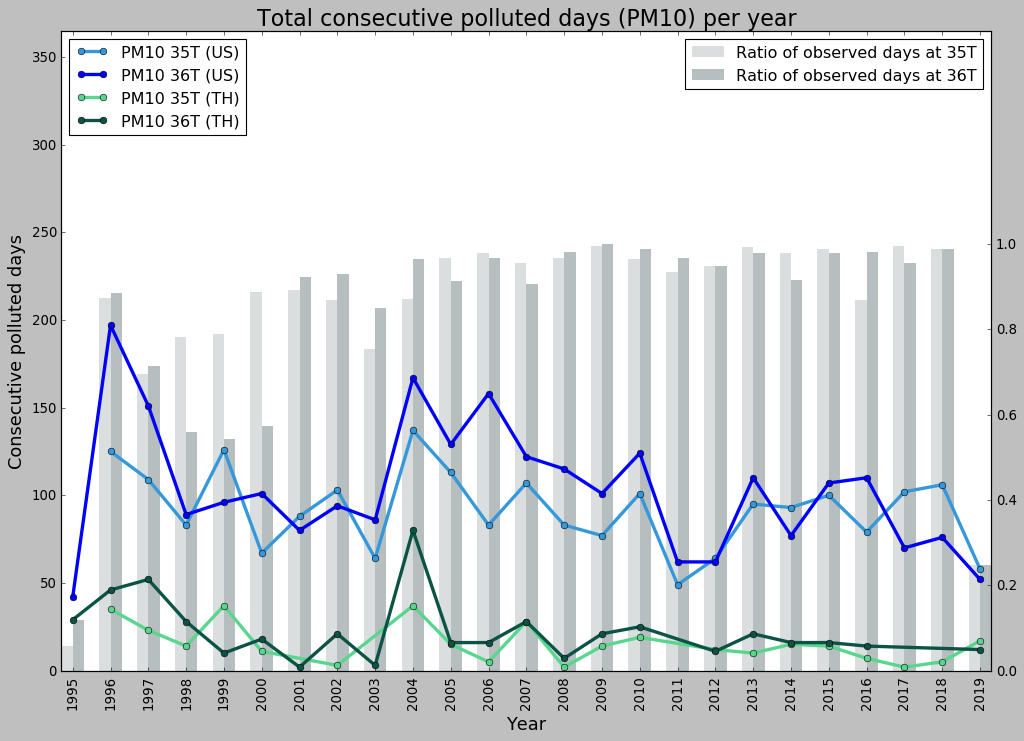

In [1087]:
year_ls = list(PM_df['year'])
year_df = pd.DataFrame(year_ls,columns=['year'])

plt.rcParams['figure.figsize'] = [15, 10] # enlarge the default plotting size

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# Plot bars first
w = 0.3
ax1.bar([x-w/2 for x in year_ls],PM_df['PM10_35T_data_R'],width=w,color='#CCD1D1',alpha=0.7,align='center',edgecolor = "none",label="Ratio of observed days at 35T")
ax1.bar([x+w/2 for x in year_ls],PM_df['PM10_36T_data_R'],width=w,color='#99A3A4',alpha=0.7,align='center',edgecolor = "none",label="Ratio of observed days at 36T")

# Format axis labels and ticks
ax1.xaxis.set_ticks(year_ls)
ax1.set_xticklabels(year_ls,rotation=90, fontsize=s)
ax1.set_ylim(0, 1.5)
ax1.yaxis.set_ticks([0,0.2,0.4,0.6,0.8,1.0])
ax1.yaxis.tick_right()

#ax1.yaxis.set_label_position("right")
#ax1.bar(year_ls,PM_df['PM10_36T_data_R'],color='b',alpha=0.2)


consec_PM10_35T_us = df_consec[(df_consec['station']=='35T') & (df_consec['PM_size']==10) & (df_consec['standard']=='us')].groupby('year').sum()
consec_PM10_36T_us = df_consec[(df_consec['station']=='36T') & (df_consec['PM_size']==10) & (df_consec['standard']=='us')].groupby('year').sum()
consec_PM10_35T_th = df_consec[(df_consec['station']=='35T') & (df_consec['PM_size']==10) & (df_consec['standard']=='th')].groupby('year').sum()
consec_PM10_36T_th = df_consec[(df_consec['station']=='36T') & (df_consec['PM_size']==10) & (df_consec['standard']=='th')].groupby('year').sum()

consec_PM10_35T_us2 = pd.merge(consec_PM10_35T_us[['consec_days']], year_df, on='year', how='right').dropna()
consec_PM10_36T_us2 = pd.merge(consec_PM10_36T_us[['consec_days']], year_df, on='year', how='right').dropna()
consec_PM10_35T_th2 = pd.merge(consec_PM10_35T_th[['consec_days']], year_df, on='year', how='right').dropna()
consec_PM10_36T_th2 = pd.merge(consec_PM10_36T_th[['consec_days']], year_df, on='year', how='right').dropna()

# Plot line charts
ax2.plot(consec_PM10_35T_us2.year, consec_PM10_35T_us2.consec_days, marker="o", color='#3498DB', linewidth=3, label='PM10 35T (US)')
ax2.plot(consec_PM10_36T_us2.year, consec_PM10_36T_us2.consec_days, marker="o", color='b', linewidth=3, label='PM10 36T (US)')
ax2.plot(consec_PM10_35T_th2.year, consec_PM10_35T_th2.consec_days, marker="o", color='#58D68D', linewidth=3, label='PM10 35T (TH)')
ax2.plot(consec_PM10_36T_th2.year, consec_PM10_36T_th2.consec_days, marker="o", color='#0B5345', linewidth=3, label='PM10 36T (TH)')
ax2.yaxis.tick_left()
ax2.yaxis.set_label_position("left")
ax2.set_ylim(0, 365)

# Add legend
ax2.legend(loc=2)
ax1.legend(loc=1)

ax2.set_ylabel('Consecutive polluted days',fontsize = m)
ax1.set_xlabel("Year", fontsize=m)
plt.title('Total consecutive polluted days (PM10) per year', loc='Center', fontsize=l, fontweight=0)


plt.savefig(figure_path+'figure12.png',dpi=300)
plt.show()

## 6.2 Total number of consecutive polluted days of PM2.5 (Figure 12)
Number of consecutive pulluted days (>2 consecutive polluted days of PM10) in each year.

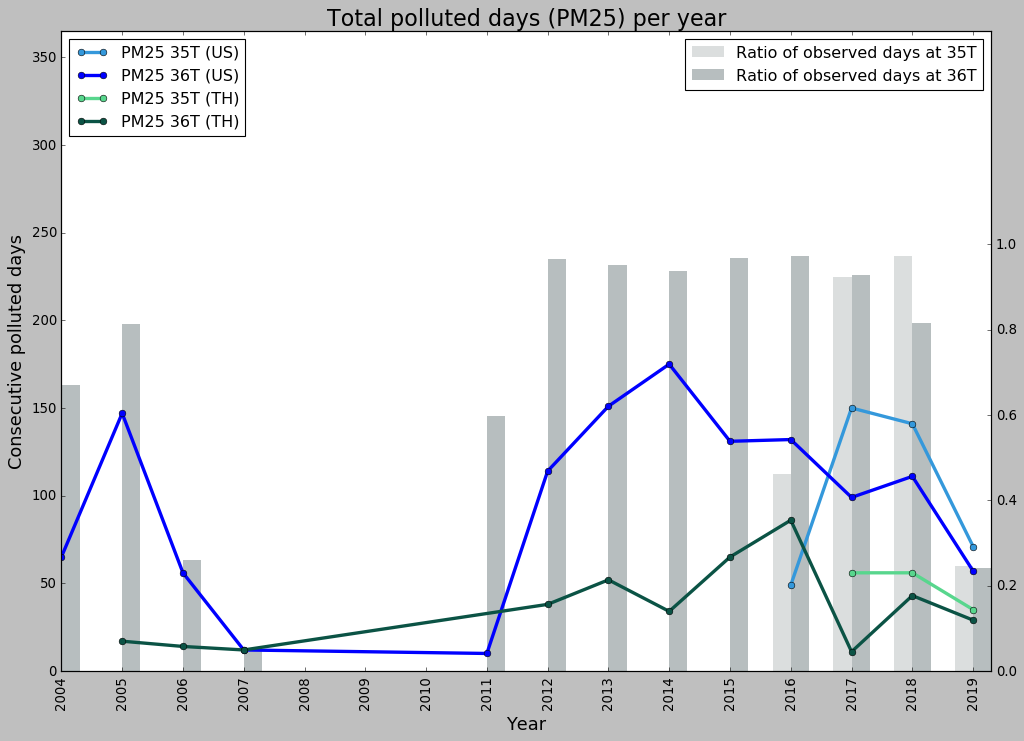

In [1080]:
year_ls = list(PM_df['year'])
year_df = pd.DataFrame(year_ls,columns=['year'])

plt.rcParams['figure.figsize'] = [15, 10] # enlarge the default plotting size

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# Plot bars first
w = 0.3
ax1.bar([x-w/2 for x in year_ls],PM_df['PM25_35T_data_R'],width=w,color='#CCD1D1',alpha=0.7,align='center',edgecolor = "none",label="Ratio of observed days at 35T")
ax1.bar([x+w/2 for x in year_ls],PM_df['PM25_36T_data_R'],width=w,color='#99A3A4',alpha=0.7,align='center',edgecolor = "none",label="Ratio of observed days at 36T")

# Format axis labels and ticks
ax1.xaxis.set_ticks(year_ls)
ax1.set_xticklabels(year_ls,rotation=90, fontsize=s)
ax1.set_ylim(0, 1.5)
ax1.yaxis.set_ticks([0,0.2,0.4,0.6,0.8,1.0])
ax1.yaxis.tick_right()

#ax1.yaxis.set_label_position("right")
#ax1.bar(year_ls,PM_df['PM25_36T_data_R'],color='b',alpha=0.2)


consec_PM25_35T_us = df_consec[(df_consec['station']=='35T') & (df_consec['PM_size']==2.5) & (df_consec['standard']=='us')].groupby('year').sum()
consec_PM25_36T_us = df_consec[(df_consec['station']=='36T') & (df_consec['PM_size']==2.5) & (df_consec['standard']=='us')].groupby('year').sum()
consec_PM25_35T_th = df_consec[(df_consec['station']=='35T') & (df_consec['PM_size']==2.5) & (df_consec['standard']=='th')].groupby('year').sum()
consec_PM25_36T_th = df_consec[(df_consec['station']=='36T') & (df_consec['PM_size']==2.5) & (df_consec['standard']=='th')].groupby('year').sum()

consec_PM25_35T_us2 = pd.merge(consec_PM25_35T_us[['consec_days']], year_df, on='year', how='right').dropna()
consec_PM25_36T_us2 = pd.merge(consec_PM25_36T_us[['consec_days']], year_df, on='year', how='right').dropna()
consec_PM25_35T_th2 = pd.merge(consec_PM25_35T_th[['consec_days']], year_df, on='year', how='right').dropna()
consec_PM25_36T_th2 = pd.merge(consec_PM25_36T_th[['consec_days']], year_df, on='year', how='right').dropna()

# Plot line charts
ax2.plot(consec_PM25_35T_us2.year, consec_PM25_35T_us2.consec_days, marker="o", color='#3498DB', linewidth=3, label='PM25 35T (US)')
ax2.plot(consec_PM25_36T_us2.year, consec_PM25_36T_us2.consec_days, marker="o", color='b', linewidth=3, label='PM25 36T (US)')
ax2.plot(consec_PM25_35T_th2.year, consec_PM25_35T_th2.consec_days, marker="o", color='#58D68D', linewidth=3, label='PM25 35T (TH)')
ax2.plot(consec_PM25_36T_th2.year, consec_PM25_36T_th2.consec_days, marker="o", color='#0B5345', linewidth=3, label='PM25 36T (TH)')
ax2.yaxis.tick_left()
ax2.yaxis.set_label_position("left")
ax2.set_ylim(0, 365)

# Add legend
ax2.legend(loc=2)
ax1.legend(loc=1)

ax2.set_ylabel('Consecutive polluted days',fontsize = m)
ax1.set_xlabel("Year", fontsize=m)
plt.title('Total polluted days (PM25) per year', loc='Center', fontsize=l, fontweight=0)


plt.savefig(figure_path+'figure13.png',dpi=300)
plt.show()